# The warehouse location problem

We have $N$ customers and $M$ locations. We want to determine the optimal location of the warehouses, so that each customer is served by exactly one warehouse and minimize the transportation costs and the fixed costs from the warehouses.

The model

Variables: 
- $X_{ij}\in \{0,1\}$, $i=1,2,...,N$, $j=1,2,...,M$ assign or not customer $i$ to warehouse $j$,
- $Y_j\in \{0,1\}$, $j=1,2,...,M$ build or not warehause $j$

Constraints:
- $\sum_{j=1}^{M} X_{ij} = 1$ each customer is served by exactly one warehause
- $X_{i,j} \leq Y_j$, $i=1,2,...,N$, $j=1,2,...,M$, can't serve a customer if warehause is not build

Objective:
$\min \left( \sum_{ij}(\text{transportation_cost}_{ij}  X_{ij}) + \sum_j (\text{fixedcost}_j Y_j) \right)$

In [1]:
library(ggplot2)
library(data.table)
library(ROI)
library(ggmap)
library(ramify)
library(ggrepel)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
ROI: R Optimization Infrastructure
Registered solver plugins: nlminb, lpsolve.
Default solver: auto.
Warning message:
“package ‘ggmap’ was built under R version 3.6.3”Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.

Attaching package: ‘ramify’

The following object is masked from ‘package:graphics’:

    clip



Source : http://tile.stamen.com/terrain/10/572/388.png
Source : http://tile.stamen.com/terrain/10/573/388.png
Source : http://tile.stamen.com/terrain/10/574/388.png
Source : http://tile.stamen.com/terrain/10/575/388.png
Source : http://tile.stamen.com/terrain/10/572/389.png
Source : http://tile.stamen.com/terrain/10/573/389.png
Source : http://tile.stamen.com/terrain/10/574/389.png
Source : http://tile.stamen.com/terrain/10/575/389.png
Source : http://tile.stamen.com/terrain/10/572/390.png
Source : http://tile.stamen.com/terrain/10/573/390.png
Source : http://tile.stamen.com/terrain/10/574/390.png
Source : http://tile.stamen.com/terrain/10/575/390.png


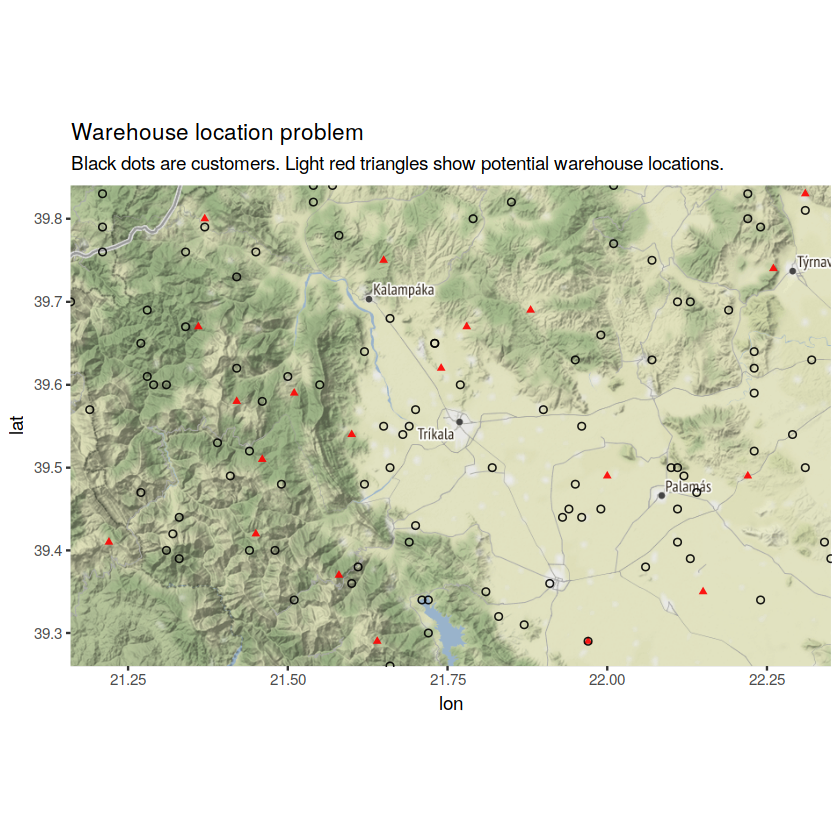

In [2]:
set.seed(123)

#Create dummy data
#GRID_SIZE = 1000
N = 100
M = 20

coord_init = c(   21.759884 , 39.553464 )

customer_locations = as.data.table(round(data.frame(
x = jitter(rep(coord_init[1], N), amount = 0.6),
y = jitter(rep( coord_init[2], N), amount = 0.3)
), digits = 2))

warehouse_locations = as.data.table(round(data.frame(
x = jitter(rep(coord_init[1], M), amount = 0.6),
y = jitter(rep( coord_init[2], M), amount = 0.3)
), digits = 2))

fixedcost <- round(rnorm(M, mean = 10000, sd = 1000))



#Transport cost function (i,j) from customer to warehause
deg2rad <- function(deg) return(deg*pi/180)
gcd.hf <- function(long1, lat1, long2, lat2) {
    R <- 6371 # Earth mean radius [km]
    delta.long <- (long2 - long1)
    delta.lat <- (lat2 - lat1)
    a <- sin(delta.lat/2) ^2  + cos(lat1) * cos(lat2) * sin(delta.long/2)^2
    test <- sapply(sqrt(a), function(x) min(1,x))
    d <- 2 * R  * asin(test)
    #  return(d *1000) # Distance in m
    return(d) # Distance in km
}
hav_dist <- function(lon_1,lat_1,lon_2,lat_2){
    gcd.hf(deg2rad(lon_1),deg2rad(lat_1),deg2rad(lon_2),deg2rad(lat_2))
}
transportcost <- function(i, j) {
  customer <- customer_locations[i, ]
  warehouse <- warehouse_locations[j, ]
  #just rounded distance
  round(hav_dist(customer$x, customer$y, warehouse$x, warehouse$y)*100)
}


bbox = c(min(c(customer_locations$x, warehouse_locations$x)), min(c(customer_locations$y, warehouse_locations$y)),
         max(c(customer_locations$x, warehouse_locations$x)), max(c(customer_locations$y, warehouse_locations$y)))

map = get_stamenmap(bbox = bbox)

print(ggmap(map) +
geom_point(aes(x=x, y=y), data=warehouse_locations, color = "red", alpha = 0.9, shape = 17) +
geom_point(aes(x=x, y=y), data=customer_locations, color = "black", alpha = 0.9, shape = 1) +
ggtitle("Warehouse location problem", 
            "Black dots are customers. Light red triangles show potential warehouse locations."))



In [3]:
#A function to return the flatened index of the variable
flat_idx = function(m,n,mVar, nVar){
    #m fast
    #n slow
    return(mVar*(n-1) + m)
}

#Build variables and objective
write_objective = function(mVar, nVar){
  varX_col_idx = 1:(mVar*nVar)
  varY_col_idx = ((mVar*nVar)+1):((mVar*nVar)+1 + mVar)
  #objective
  obj = matrix(NA, nrow = N*M+M)
  for(n_idx in 1:N){
      obj[flat_idx(1:M, n_idx, M, N)] = transportcost(n_idx,1:M)
      obj[N*M + 1:M] = fixedcost[1:M]
    }
  return(list(varX_col_idx,
              varY_col_idx,
              c(obj)))
}


#Build Contraints
write_X_requirements = function(n_idx, mVar, nVar){
    
    row_idx = rep(0,mVar*nVar + mVar) #the coefficient of all the variables
    row_idx[flat_idx(1:mVar, n_idx, mVar, nVar)] = 1
    return(row_idx)
    
}



write_Y_requirements = function(m_idx, n_idx, mVar, nVar){
   
    row_idx = rep(0,mVar*nVar + mVar)
    row_idx[flat_idx(m_idx, n_idx, mVar, nVar)] = 1 #coeficients of X
    row_idx[mVar*nVar + m_idx] = -1 #coefficients of Y
    return(row_idx)
}



In [4]:
write_constraints = function(mVar, nVar){
  
  all_rows <- c()
  all_dirs <- c()
  all_rhss <- c()
  n_rows <- 0
  
  print("Writing X requirements ...")
  #Write X requirements
  for (n in 1:nVar){
    reqs = write_X_requirements(n, mVar, nVar)
    all_rows = append(all_rows, reqs)
    all_dirs = append(all_dirs, "==")
    all_rhss = append(all_rhss, 1)
    n_rows = n_rows + 1
  }
  
  print("Writing Y requirements ...")
  #Write Y requirements
  for (n_idx in 1:nVar){
      for(m_idx in 1:mVar){
       
          yConstraints <- write_Y_requirements(m_idx, n_idx, mVar, nVar)
          all_rows <- append(all_rows, yConstraints)
          all_dirs <- append(all_dirs, "<=")
          all_rhss <- append(all_rhss, 0)
          n_rows <- n_rows + 1
          
      }
  }
  
  f.con <- matrix(all_rows, nrow = n_rows, byrow = TRUE)
  f.dir <- all_dirs
  f.rhs <- all_rhss
  return(list(f.con, f.dir, f.rhs))
  
}

constraints <- write_constraints(
  mVar = M,
  nVar = N
)
f.con <- constraints[[1]]
f.dir <- constraints[[2]]
f.rhs <- constraints[[3]]

res = write_objective(M, N)
f.obj = res[[3]]
varX_col_idx = res[[1]]
varY_col_idx = res[[2]]

#Solve
milp <- OP(
  objective = L_objective(f.obj),
  constraints = L_constraint(L = f.con, dir = f.dir, rhs = f.rhs),
  types = rep("B", length(f.obj)), #All binary
  maximum = FALSE
)
sol <- ROI_solve(milp)
print(sol$solution)

[1] "Writing X requirements ..."
[1] "Writing Y requirements ..."
   [1] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [75] 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [149] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [223] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 [260] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 [297] 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 [334] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [371] 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [408] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

In [5]:
#add ids
customer_locations[,id:=1:.N]
colnames(customer_locations) = paste0(colnames(customer_locations), "_c") 
warehouse_locations[,id:=1:.N]
colnames(warehouse_locations) = paste0(colnames(warehouse_locations), "_w")
varX = as.data.table(matrix(sol$solution[varX_col_idx],nrow = N, byrow=TRUE))
varY = sol$solution[varY_col_idx]

customer_locations[,id_w:= argmax(varX, rows = T)]

In [6]:
plot_assignment = merge(customer_locations, warehouse_locations, by='id_w')
customer_count = plot_assignment[,.(customer_count= .N), by=.(id_w)]
warehouse_locations[,costs := fixedcost]
plot_warehouses = merge(warehouse_locations, customer_count, by="id_w")

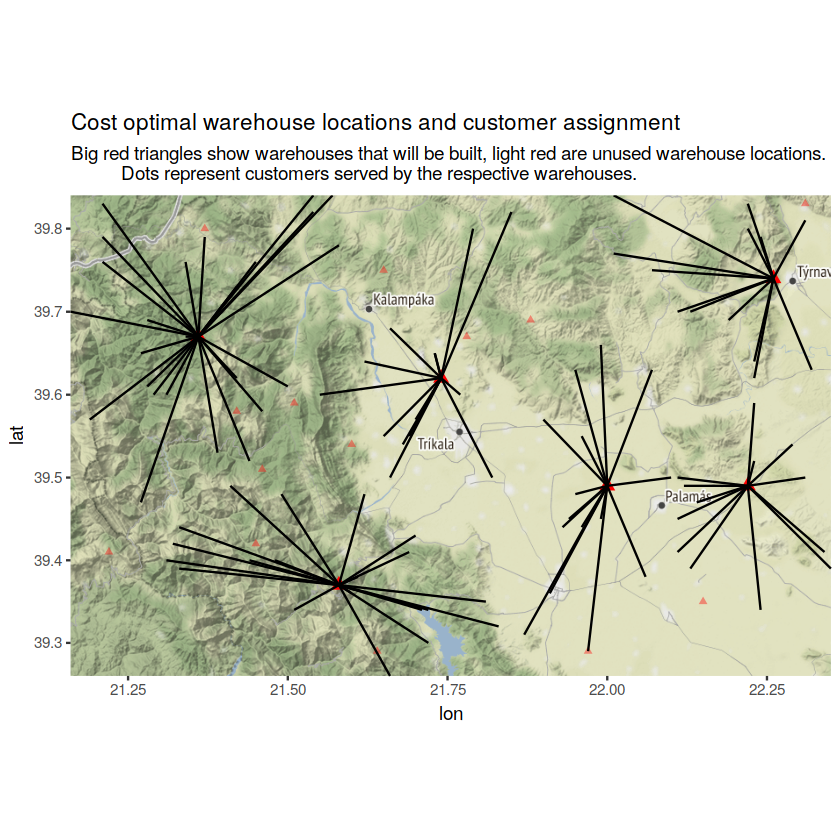

In [7]:
print(ggmap(map)+
      geom_point(aes(x=x_w, y=y_w), data  = plot_warehouses, color = "red", size = 3, shape = 17) +
      geom_point(aes(x=x_w, y=y_w), data=warehouse_locations, color = "red", alpha = 0.4, shape = 17) +
      geom_segment(data = plot_assignment, aes(x = x_w, y = y_w, xend = x_c, yend = y_c)) +
      ggtitle(paste0("Cost optimal warehouse locations and customer assignment"),
          "Big red triangles show warehouses that will be built, light red are unused warehouse locations. 
          Dots represent customers served by the respective warehouses.") )

In [8]:
plot_warehouses

id_w,x_w,y_w,costs,customer_count
6,22.22,39.49,9348,13
9,21.36,39.67,9038,25
11,21.74,39.62,11445,14
16,22.00,39.49,11131,15
17,21.58,39.37,8539,20
20,22.26,39.74,8556,13


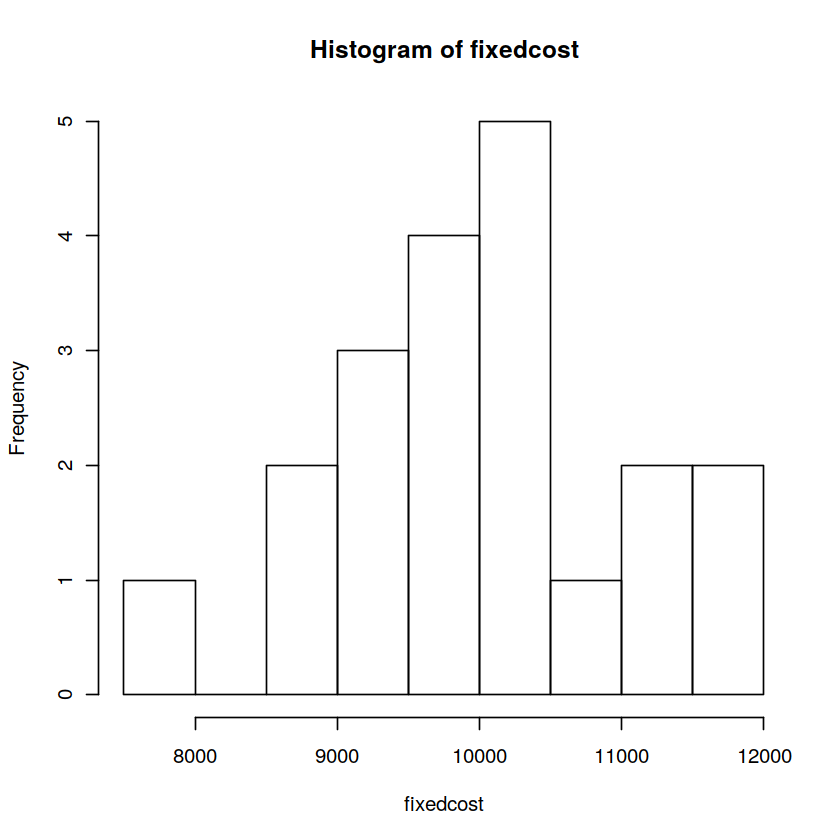

In [9]:
hist(fixedcost)